# Intro ML Homework 6
## Name: Jaskin Kabir
## Student ID: 801186717
Github: https://github.com/jaskinkabir/Intro_ML/tree/main/HM5

In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn


path = 'housing.csv'
housing = pd.DataFrame(pd.read_csv(path))

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

df_train, df_test = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

Y_train_p1 = df_train.pop('price')
X_train = df_train

Y_test_p1 = df_test.pop('price')
X_test = df_test
X_train.head()


b_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X_p3 = housing[b_vars]
X_train_df_p3 = X_train[b_vars]
X_test_df_p3 = X_test[b_vars]

X_train_p1 = X_train_df_p3.to_numpy()
X_test_p1 = X_test_df_p3.to_numpy()

scaler = preprocessing.StandardScaler().fit(X_train_p1)
X_train_p1 = scaler.transform(X_train_p1)
X_test_p1 = scaler.transform(X_test_p1)




In [18]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

class Regressor(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print(100 * (results1 - results2) / results1)
        
    def __init__(self, in_dim, out_dim, hidden_layers=[64,32], activation=nn.Tanh,):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.input_cols = []
        self.output_cols = []
        
        #Error Mode is a 5 bit integer, with each bit representing a feature
        # If the bit is 1, the feature is errored
        output_features = out_dim
        input_features = in_dim
        

        
        self.stack_list = [nn.Linear(input_features, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])
        self.stack_list.extend([nn.Linear(hidden_layers[-1], output_features)])
        self.stack = nn.Sequential(*self.stack_list)
        
        
        
    def train(self, epochs, X_train, X_test, Y_tr, Y_te, alpha=1e-2, loss_fn=nn.MSELoss(),):
        
        val_hist = np.zeros(epochs)
        train_hist = np.zeros(epochs)

        optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        for i in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred, Y_train_p1)
            loss.backward()
            optimizer.step()
            
            train_hist[i] = np.sqrt(loss.item())
            Y_pred = self.forward(X_test)
            val_hist[i] = np.sqrt(loss_fn(Y_pred, Y_te).item())
            
        self.last_test = Y_test_p1
        self.last_pred = self.forward(X_test)
        self.last_score = val_hist[-1]
        
        self.last_epochs = epochs
        self.last_val_hist = val_hist
        self.last_train_hist = train_hist
    
    def plot_loss(self, title):
        
        plt.plot(range(self.last_epochs), self.last_val_hist, label='Validation Loss')
        plt.plot(range(self.last_epochs), self.last_train_hist, label='Training Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('RMS Loss')
        plt.legend()
        plt.show()
        
    def forward(self, x):
        return self.stack(x)
    
    def print_results(self):
        if self.last_score is None:
            raise ValueError('No results to print')
        print(f'MSE: {self.last_score:.2E}')
        
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_val=0.0):
        super(CustomMSELoss, self).__init__()
        self.lambda_val = lambda_val
    
    def forward(self, predictions, targets):

        m = targets.size(0)
        
        errors = predictions - targets
        mse_loss = (1 / (2*m)) * torch.sum(errors ** 2)
        

        

        total_loss = mse_loss
        
        return total_loss

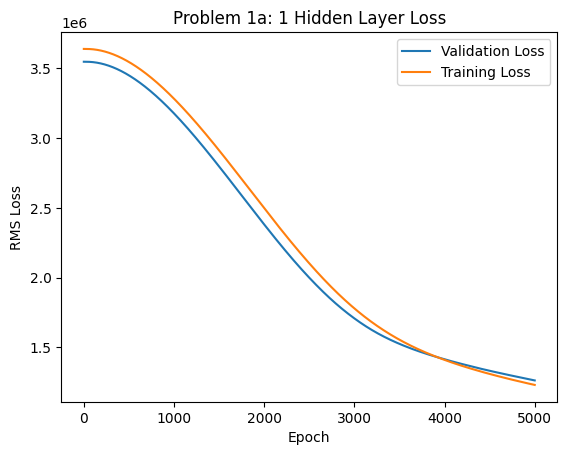

MSE: 1.26E+06


In [19]:


device = 'cpu'


X_train_p1 = torch.tensor(X_train_p1).to(device).float()
X_test_p1 = torch.tensor(X_test_p1).to(device).float()

Y_train_p1 = torch.tensor(Y_train_p1.to_numpy()).to(device).float().view(-1, 1)
Y_test_p1 = torch.tensor(Y_test_p1.to_numpy()).to(device).float().view(-1, 1)


model_1 = Regressor(
    in_dim=X_train_p1.shape[1],
    out_dim=1,
    hidden_layers=[8],
    activation=nn.ReLU,
).to(device)

model_1.train(
    epochs=5000,
    X_train=X_train_p1,
    X_test=X_test_p1,
    Y_tr=Y_train_p1,
    Y_te=Y_test_p1,
    alpha=1e-1,
    loss_fn=CustomMSELoss(),
)

model_1.plot_loss('Problem 1a: 1 Hidden Layer Loss')
model_1.print_results()

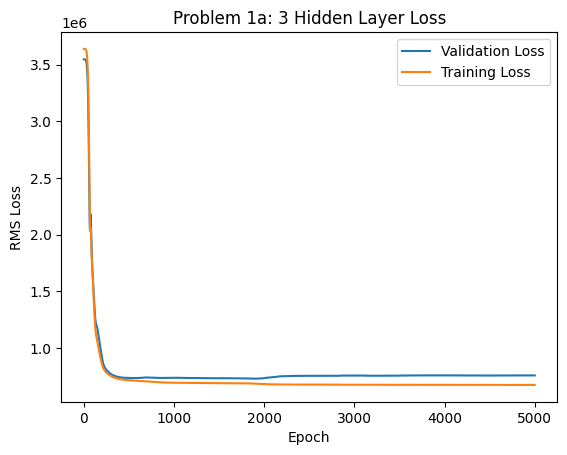

MSE: 7.60E+05


In [20]:
model_2 = Regressor(
    in_dim=X_train_p1.shape[1],
    out_dim=1,
    hidden_layers=[8,8,8],
    activation=nn.ReLU,
).to(device)


model_2.train(
    epochs=5000,
    X_train=X_train_p1,
    X_test=X_test_p1,
    Y_tr=Y_train_p1,
    Y_te=Y_test_p1,
    alpha=1e-1,
    loss_fn=CustomMSELoss(),
)

model_2.plot_loss('Problem 1a: 3 Hidden Layer Loss')
model_2.print_results()

In [ ]:
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()
X_2 = breast.data
Y_2 = breast.target

X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2, Y_2, train_size=0.8, test_size=0.2, random_state=00)

scaler = preprocessing.StandardScaler().fit(X_train_2)
X_train_2 = scaler.transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
class LogisticClassifier(nn.Module):

    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self, input_dim=0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        if pass_through:
            return
        self.stack_list = [nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.extend([nn.Linear(hidden_layers[-1], 1), nn.Sigmoid()]) 
        self.stack = nn.Sequential(*self.stack_list)
        
    def forward(self, x):
        return self.stack(x)
    
    def predict(self, x):
        return self.forward(x).round()
    
    def train(self, epochs, X_train, X_test, Y_train, Y_test, alpha, loss_fn=nn.BCELoss(), print_epoch=500):
        optimizer = torch.optim.Adam(self.parameters(), lr=alpha)

        for epoch in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred, Y_train)
            loss.backward()
            optimizer.step()
            if epoch % print_epoch == 0:
                print(f'Epoch {epoch} Loss: {loss.item()}')
        Y_pred = self.predict(X_test)
        self.last_pred = Y_pred
        self.last_test = Y_test
        return [Y_test,Y_pred]
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
        Y_test = Y_test.cpu().detach().numpy()
        Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred),
            'recall': recall_score(Y_test, Y_pred),
            'f1': f1_score(Y_test, Y_pred),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key != 'confusion_matrix':
                print(f'{key.capitalize()}: {value}')
            else:
                print(f'{key.capitalize()}:\n{value}')
    
    def train_and_print(self, epochs, X_train, X_test, Y_train, Y_test, alpha):
        Y_pred = self.train(epochs, X_train, X_test, Y_train, Y_test, alpha).cpu().detach().numpy().round().astype(int)
        self.print_results(Y_test, Y_pred)